In [ ]:
from google.colab import files

# Upload your ZIP file
uploaded = files.upload()


Saving fakeReal(1).zip to fakeReal(1).zip


In [ ]:
import zipfile
import os

# Path to uploaded file (adjust if filename is different)
zip_path = "/content/fakeReal(1).zip"
extract_path = "/content/news_data"

# Unzip it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check contents
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))


/content/news_data/BuzzFeed_real_news_content.csv
/content/news_data/BuzzFeedUserFeature.mat
/content/news_data/PolitiFact_real_news_content.csv
/content/news_data/PolitiFactNews.txt
/content/news_data/BuzzFeedNews.txt
/content/news_data/BuzzFeed_fake_news_content.csv
/content/news_data/PolitiFactUser.txt
/content/news_data/BuzzFeedUserUser.txt
/content/news_data/PolitiFactUserUser.txt
/content/news_data/BuzzFeedUser.txt
/content/news_data/PolitiFactNewsUser.txt
/content/news_data/PolitiFact_fake_news_content.csv
/content/news_data/BuzzFeedNewsUser.txt
/content/news_data/PolitiFactUserFeature.mat


In [ ]:
import pandas as pd

# Load fake and real news data
fake_df = pd.read_csv("/content/news_data/News _dataset/Fake.csv")
real_df = pd.read_csv("/content/news_data/News _dataset/True.csv")

# Add a 'label' column: 1 for fake, 0 for real
fake_df['label'] = 1
real_df['label'] = 0

# Combine the datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())


FileNotFoundError: [Errno 2] No such file or directory: '/content/news_data/News _dataset/Fake.csv'

In [ ]:

# Load fake and real news data
fake_df = pd.read_csv("/content/news_data/News _dataset/Fake.csv")
real_df = pd.read_csv("/content/news_data/News _dataset/True.csv")

# Add a 'label' column: 1 for fake, 0 for real
fake_df['label'] = 1
real_df['label'] = 0

# Combine the datasets
df = pd.concat([fake_df, real_df], ignore_index=True)

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Preview
print(df.head())
print("\nLabel distribution:\n", df['label'].value_counts())


                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
3         May 22, 2017      1  
4       June 24, 2016       0  

Label distribution:
 label
1    23481
0    21417


In [ ]:
pip install torch torchvision torchaudio torch-geometric scikit-learn

In [ ]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data

# Generate sentence embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# KNN for graph edges
k = 5
nbrs = NearestNeighbors(n_neighbors=k + 1, metric='cosine').fit(embeddings)
_, indices = nbrs.kneighbors(embeddings)

# Build edge index (skip self-loop)
edge_list = []
for i, neighbors in enumerate(indices):
    for j in neighbors[1:]:
        edge_list.append([i, j])

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Features and labels
x = torch.tensor(embeddings, dtype=torch.float)
y = torch.tensor(df['label'].values, dtype=torch.long)

# Create graph
data = Data(x=x, edge_index=edge_index, y=y)


Batches:   0%|          | 0/1404 [00:00<?, ?it/s]

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(input_dim=x.shape[1], hidden_dim=64, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.NLLLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Run training
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f}")

Epoch 10 | Loss: 0.3391
Epoch 20 | Loss: 0.2839
Epoch 30 | Loss: 0.2599
Epoch 40 | Loss: 0.2450
Epoch 50 | Loss: 0.2342
Epoch 60 | Loss: 0.2250
Epoch 70 | Loss: 0.2171
Epoch 80 | Loss: 0.2107
Epoch 90 | Loss: 0.2056
Epoch 100 | Loss: 0.2016


In [ ]:
def evaluate():
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum().item()
        acc = correct / len(data.y)
    return acc

In [ ]:
acc = evaluate()
print(f"Final Accuracy: {acc:.4f}")

Final Accuracy: 0.9235


Epoch 010 | Loss: 0.1975 | Accuracy: 0.9251
Epoch 020 | Loss: 0.1941 | Accuracy: 0.9266
Epoch 030 | Loss: 0.1919 | Accuracy: 0.9268
Epoch 040 | Loss: 0.1881 | Accuracy: 0.9277
Epoch 050 | Loss: 0.1854 | Accuracy: 0.9297
Epoch 060 | Loss: 0.1820 | Accuracy: 0.9300
Epoch 070 | Loss: 0.1810 | Accuracy: 0.9314
Epoch 080 | Loss: 0.1762 | Accuracy: 0.9321
Epoch 090 | Loss: 0.1740 | Accuracy: 0.9336
Epoch 100 | Loss: 0.1712 | Accuracy: 0.9348


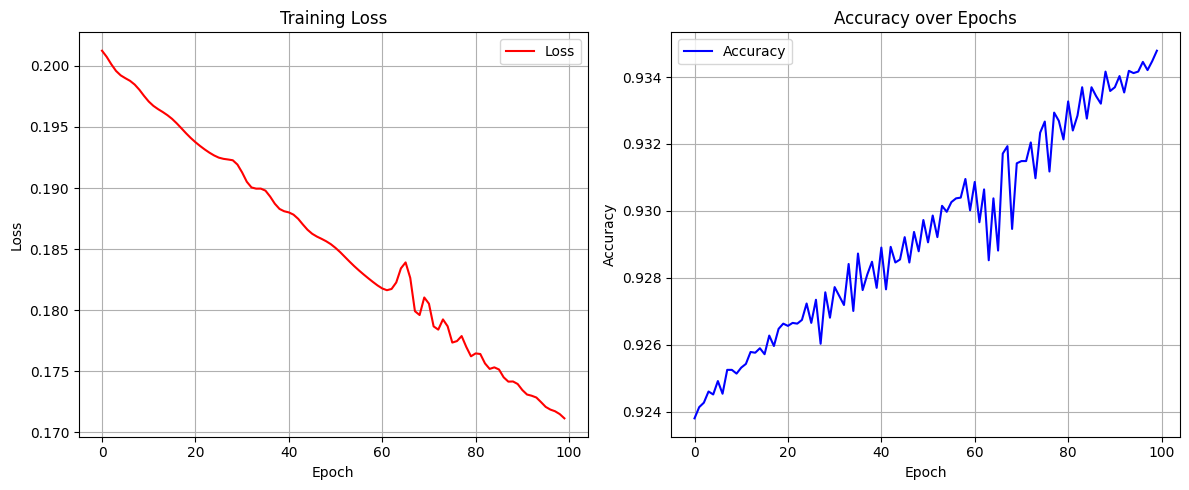

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

losses = []
accuracies = []

for epoch in range(1, 101):
    loss = train()
    acc = evaluate()
    losses.append(loss)
    accuracies.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")

# Plot loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy', color='blue')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "gcn_model.pth")

In [ ]:
torch.save(data, "graph_data.pt")

In [ ]:
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Choose a folder path in your Drive (you can change this)
save_path = "/content/drive/MyDrive/FakeNewsGNN"

# Create the folder if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save model and graph (with correct closing parentheses)
torch.save(model.state_dict(), f"{save_path}/gcn_model.pth")
torch.save(data, f"{save_path}/graph_data.pt")

NameError: name 'torch' is not defined

In [ ]:
import os

# List files in the save directory
saved_files = os.listdir("/content/drive/MyDrive/FakeNewsGNN")
print("Saved files:", saved_files)

Saved files: ['gcn_model.pth', 'graph_data.pt']
